# systematics with the Asimov dataset

To assess the impact of various sources of systematic, we will rely on an Asimov dataset.

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=3)
matplotlib.style.use('default')
params = {'legend.fontsize': 20,
          'axes.labelsize': 20,
          'figure.figsize': (8, 8),
          'axes.facecolor': 'white',
          'axes.titlesize':'x-large',
          'xtick.labelsize':18,
          'ytick.labelsize':18,
         }
matplotlib.rcParams.update(params)
%matplotlib inline

/home/naodell/work/wbr/analysis


In [2]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'data/templates/bjet_binned_test/'
selections = [
              'emu', 
              'ee', 'mumu', 
              'mutau', 'etau', 
              'mu4j', 'e4j'
             ]
n_selection = len(selections)
targets    = dict(
                  mumu  = 'lepton2_pt', 
                  ee    = 'lepton2_pt', 
                  emu   = 'trailing_lepton_pt', 
                  mutau = 'lepton2_pt', 
                  etau  = 'lepton2_pt', 
                  mu4j  = 'lepton1_pt',
                  e4j   = 'lepton1_pt'
                 )
plot_labels = dict(
                   mumu  = [r'$\sf p_{T, \mu}$', r'$\mu\mu$'],
                   ee    = [r'$\sf p_{T, e}$', r'$ee$'],
                   emu   = [r'$\sf p_{T, \ell}$', r'$e\mu$'],
                   mutau = [r'$\sf p_{T, \tau}$', r'$\mu\tau$'],
                   etau  = [r'$\sf p_{T, \tau}$', r'$e\tau$'],
                   mu4j  = [r'$\sf p_{T, \mu}$', r'$\mu$ + jet'],
                   e4j   = [r'$\sf p_{T, e}$', r'$e$ + jet']
                  )
#p_labels = [r'$\beta_{e}$', r'$\beta_{\mu}$', r'$\beta_{\tau}$', r'$\beta_{h}$',
#            r'$\sf L_{int}$', 
#            r'$\sigma_{t\bar{t}}$',  r'$\sigma_{z}$',  r'$\sigma_{w}$', r'$\sf k_{fakes}$', 
#            r'$\sf \epsilon_{e}$', r'$\sf \epsilon_{\mu}$', r'$\sf \epsilon_{\tau}$']

p_labels = ['B_e', 'B_mu', 'B_tau', 'B_h', 'L', 'sigma_tt', 'sigma_z', 'sigma_w', 'k_fake', 'eff_e', 'eff_mu', 'eff_tau', 'escale_e', 'escale_mu', 'escale_tau', 'pileup']

# initial values for W branching fraction (beta_e, beta_mu, beta_tau, beta_h) and tau branching fraction (b_e, b_mu, b_h)
br_tau    = [0.1783, 0.1741, 0.6476]
beta_init = [0.108, 0.108, 0.108, 1 - 3*0.108] 
var_beta  = [0.0009**2, 0.0009**2, 0.0009**2, 0.0031**2]

# initialize fit data
fit_data = fh.FitData(input_dir, selections, targets, bins=[1, 2])

In [3]:
# generate Asimov dataset
toy_data = dict()
for b in fit_data._bins:
    toy_data[b] = dict()
    for selection in selections:
        # signal component
        templates = fit_data.get_selection_data(selection)
        signal_template = templates[b]['signal']
        signal = fh.signal_mixture_model(beta_init, br_tau, signal_template, sample=False)[0]

        toy_data[b][selection] = signal
        # background component
        for bg in ['zjets', 'wjets', 'fakes']:
            if bg == 'fakes' and selection not in ['mu4j', 'mutau']:
                continue

            bg_template = templates[b][bg][0]
            toy_data[b][selection] += bg_template

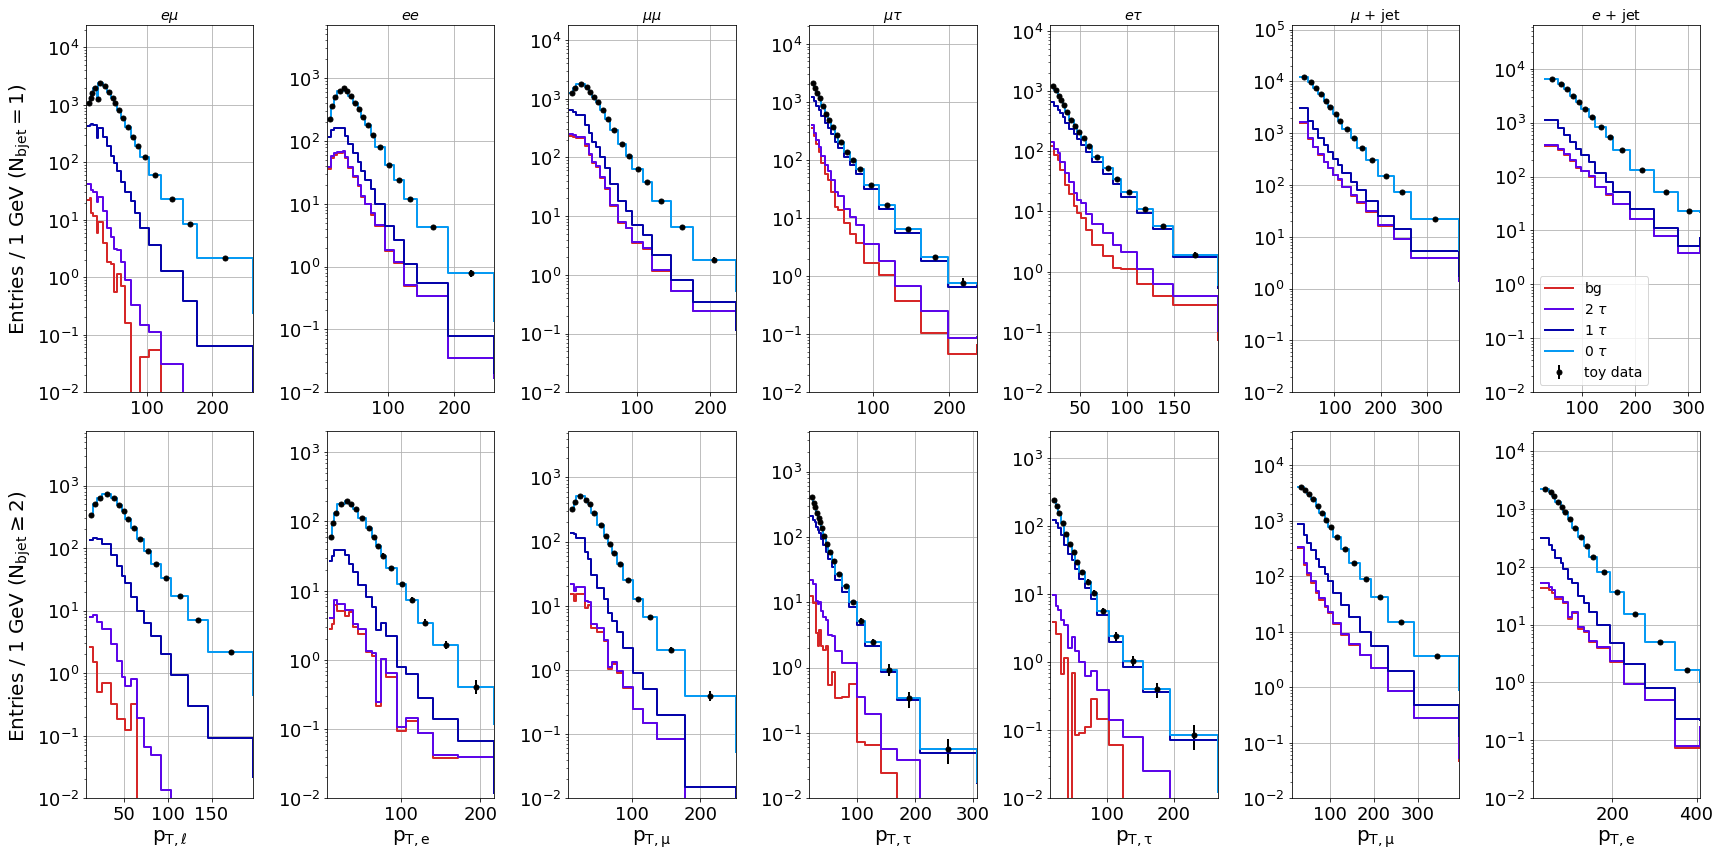

In [4]:
# visualize toy data
fig, axes = plt.subplots(2, 7, figsize=(24, 12), facecolor='white')
for i, selection in enumerate(selections):
    s_data = fit_data.get_selection_data(selection)
#
    for j, b in enumerate(fit_data._bins):
        bins = s_data[b]['bins']
        dx = (bins[1:] - bins[:-1])
        dx = np.append(dx, dx[-1]) 
        x = bins + dx/2            

        ax = axes[j][i]
        data = toy_data[b][selection]
        ax.errorbar(x, data/dx, np.sqrt(data)/dx, fmt='ko', linewidth=2., markersize=5)
        
        # validation plot
        br = 0.108
        signal = s_data[b]['signal']
        bg = s_data[b]['wjets'][0] + s_data[b]['zjets'][0]
        if selection in ['mu4j', 'mutau']:
            bg += s_data[b]['fakes'][0]
            
        h_notau   = fh.signal_mixture_model([br, br, br, 1. - 3*br], br_tau, signal, mask=fit_data._decay_map['sig_twotau']) + bg
        h_onetau  = fh.signal_mixture_model([br, br, br, 1. - 3*br], br_tau, signal, mask=fit_data._decay_map['sig_onetau']) + h_notau
        h_nominal = fh.signal_mixture_model([br, br, br, 1. - 3*br], br_tau, signal) + bg
        
        ax.plot(bins, bg/dx, drawstyle='steps-post', c='C3', linestyle='-', linewidth=2.)
        ax.plot(bins, h_notau[0]/dx, drawstyle='steps-post', c='xkcd:blue violet', linestyle='-', linewidth=2.)
        ax.plot(bins, h_onetau[0]/dx, drawstyle='steps-post', c='xkcd:royal blue', linestyle='-', linewidth=2.)
        ax.plot(bins, h_nominal[0]/dx, drawstyle='steps-post', c='xkcd:azure', linestyle='-', linewidth=2.)
        
        xmin, xmax = bins[0]-dx[0], bins[-2]+dx[-2]
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(0.01, 10.*np.max(h_nominal[0]/dx))
        ax.set_yscale('log')
        if j == 0:
            ax.set_title(plot_labels[selection][1])
            if i == 0:
                ax.set_ylabel(r'Entries / 1 GeV ($\sf N_{b jet} = 1$)')
        elif j == 1:
            ax.set_xlabel(plot_labels[selection][0])
            if i == 0:
                ax.set_ylabel(r'Entries / 1 GeV ($\sf N_{b jet} \geq 2$)')
        ax.grid()
    
    axes[0][-1].legend(['bg', r'2 $\tau$', r'1 $\tau$', r'0 $\tau$', 'toy data'], fontsize=14)
    
plt.tight_layout()
plt.savefig('plots/toy_mc_example.pdf')
plt.show()

In [5]:
# nominal case
cost_type = 'poisson'
p_init = list(fit_data.get_params_init()) + 8*[1., ] + 4*[1., ] # niceify this: nuisance parameters are initialized to 1
p_init = np.array(p_init)
fobj = partial(fit_data.objective, data=toy_data, cost_type=cost_type)
stderr, corr = fh.calculate_covariance(fobj, p_init)

In [6]:
pd.set_option('precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


#print(result.x)
#print(cov[0])
pct_err = pd.DataFrame(100*stderr/p_init, index=p_labels, columns=['stderr'])
df_corr = pd.DataFrame(corr, columns=p_labels, index=p_labels)
pct_err

,stderr
B_e,0.751
B_mu,0.642
B_tau,1.698
B_h,0.277
L,1.344
sigma_tt,1.379
sigma_z,4.528
sigma_w,5.242
k_fake,4.418
eff_e,0.732


In [7]:
df_corr.to_latex('data/cov_table_full.tex')
df_corr

,B_e,B_mu,B_tau,B_h,L,sigma_tt,sigma_z,sigma_w,k_fake,eff_e,eff_mu,eff_tau,escale_e,escale_mu,escale_tau,pileup
B_e,1.000,-0.037,-0.151,-0.272,0.009,-0.015,0.120,0.101,0.188,-0.827,0.053,0.119,0.227,-0.068,-0.038,0.026
B_mu,-0.037,1.000,-0.196,-0.162,0.013,-0.009,0.119,0.108,-0.045,0.066,-0.803,0.143,0.071,0.257,-0.052,0.022
B_tau,-0.151,-0.196,1.000,-0.840,0.047,0.113,-0.314,0.005,-0.128,-0.195,-0.203,-0.888,-0.245,-0.247,0.293,-0.293
B_h,-0.272,-0.162,-0.840,1.000,-0.055,-0.100,0.211,-0.089,0.061,0.524,0.473,0.764,0.115,0.176,-0.251,0.267
L,0.009,0.013,0.047,-0.055,1.000,-0.921,-0.238,-0.251,-0.037,-0.081,-0.073,-0.072,-0.046,0.002,0.018,0.065
sigma_tt,-0.015,-0.009,0.113,-0.100,-0.921,1.000,0.278,0.111,-0.066,-0.116,-0.119,-0.128,-0.081,-0.016,0.048,0.018
sigma_z,0.120,0.119,-0.314,0.211,-0.238,0.278,1.000,-0.050,0.277,-0.160,-0.197,0.190,0.048,-0.151,-0.093,0.206
sigma_w,0.101,0.108,0.005,-0.089,-0.251,0.111,-0.050,1.000,-0.170,0.022,0.149,-0.071,0.001,0.236,-0.053,0.403
k_fake,0.188,-0.045,-0.128,0.061,-0.037,-0.066,0.277,-0.170,1.000,0.019,0.049,0.190,0.161,-0.623,-0.032,-0.001
eff_e,-0.827,0.066,-0.195,0.524,-0.081,-0.116,-0.160,0.022,0.019,1.000,0.206,0.253,-0.017,0.074,-0.077,-0.054


In [8]:
# n-1 uncertainties
from tqdm import tqdm_notebook, trange

def reduced_objective(p, i, j=None):
    if j == None or j < i:
        j = i
        
    p = np.concatenate([p[:i], (j - i + 1)*[1,], p[j:]])
    return fit_data.objective(p, data=toy_data, cost_type=cost_type)

# stat only
fobj = partial(reduced_objective, i=4, j=len(p_init))
stderr_stat = np.concatenate([fh.calculate_covariance(fobj, p_init[:4])[0], p_init[4:].size*[0.,]])

errs = [stderr_stat]
p_init = p_init
for i in tqdm_notebook(range(4, len(p_init))):
    fobj = partial(reduced_objective, i=i)
    stderr, cov = fh.calculate_covariance(fobj, p_init[:-1])
    
    stderr = np.concatenate([stderr[:i], [0], stderr[i:]])
    errs.append(stderr)
    
# full systematics
fobj = partial(fit_data.objective, data=toy_data, cost_type=cost_type)
stderr_nominal = fh.calculate_covariance(fobj, p_init)[0]
errs.append(stderr_nominal)

HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

In [9]:
errs = pd.DataFrame(errs, columns=p_labels, index=['stat only'] + p_labels[4:] + ['full'])
errs.divide(p_init/100, axis=1)

,B_e,B_mu,B_tau,B_h,L,sigma_tt,sigma_z,sigma_w,k_fake,eff_e,eff_mu,eff_tau,escale_e,escale_mu,escale_tau,pileup
stat only,0.136,0.109,0.558,0.084,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
L,0.751,0.642,1.696,0.277,0.000,0.536,4.397,5.075,4.415,0.729,0.648,0.972,7.859,9.067,13.356,37.386
sigma_tt,0.751,0.642,1.687,0.276,0.522,0.000,4.350,5.209,4.409,0.727,0.645,0.966,7.842,9.066,13.342,37.460
sigma_z,0.746,0.637,1.612,0.271,1.305,1.324,0.000,5.235,4.246,0.722,0.637,0.957,7.858,8.963,13.299,36.661
sigma_w,0.748,0.638,1.698,0.276,1.301,1.370,4.522,0.000,4.354,0.732,0.643,0.972,7.867,8.810,13.339,34.283
k_fake,0.738,0.641,1.684,0.277,1.343,1.376,4.351,5.166,0.000,0.732,0.649,0.957,7.765,7.095,13.351,37.465
eff_e,0.422,0.640,1.665,0.236,1.339,1.369,4.470,5.241,4.418,0.000,0.636,0.943,7.866,9.042,13.318,37.411
eff_mu,0.750,0.382,1.662,0.244,1.340,1.369,4.440,5.183,4.413,0.716,0.000,0.947,7.861,9.051,13.314,37.136
eff_tau,0.746,0.635,0.782,0.179,1.340,1.367,4.445,5.228,4.338,0.708,0.632,0.000,7.537,8.931,13.098,37.342
escale_e,0.732,0.640,1.646,0.275,1.342,1.374,4.523,5.242,4.361,0.732,0.649,0.933,0.000,9.030,13.309,36.182


### Estimating individual contributions

If we make the assumption that the uncertainties sum in quadrature (which they should really given all of the correlations), we can write the total uncertainty as,

$$
\sigma_{total}^{2} = \sigma_{stat}^{2} + \sum_{i}\sigma_{i,syst}^{2}
$$

From this we can write evaluate the contribution from a single systematic source as,

$$
\sigma_{i,syst}^{2} = \sigma_{total}^{2} - \sigma_{stat}^{2} - \sum_{j\neq i}\sigma_{j,syst}^{2}
$$


In [10]:
beta_vars = errs.iloc[:,:4]**2
var_stat = beta_vars.iloc[0]
var_nom  = beta_vars.iloc[-1]

for i in trange(1, beta_vars.shape[0] - 1):
    beta_vars.iloc[i] = var_nom - beta_vars.iloc[i]
    
beta_errs = np.sqrt(beta_vars)
100*beta_errs.divide(p_init[:4], axis=1)

100%|██████████| 12/12 [00:00<00:00, 2875.27it/s]


,B_e,B_mu,B_tau,B_h
stat only,0.136,0.109,0.558,0.084
L,0.006,0.008,0.080,0.015
sigma_tt,0.012,0.006,0.192,0.028
sigma_z,0.090,0.076,0.533,0.059
sigma_w,0.076,0.069,0.009,0.025
k_fake,0.141,0.029,0.218,0.017
eff_e,0.622,0.042,0.330,0.145
eff_mu,0.040,0.516,0.345,0.131
eff_tau,0.089,0.092,1.507,0.212
escale_e,0.171,0.045,0.416,0.032
